# Extended MNIST Network

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.data import Dataset

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [3]:
%run ../Funkcije.ipynb

In [10]:
train_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Train_Alphabet'
test_path = 'D:\Projekat 2022\dataset\Synthetic ASL Alphabet\Test_Alphabet'
working_dir = r'./'

### Učitavanje baze i formiranje generatora

In [5]:
max_samples = 300
min_samples = 300
img_size = (128, 128)
batch_size = 30

horizontal_flip = True
rotation_range = 25
width_shift_range = .25
height_shift_range = .3
zoom_range = .4

after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  300
Found 7200 validated image filenames belonging to 24 classes.          for train generator 
Found 2160 validated image filenames belonging to 24 classes.          for valid generator 
Found 2400 validated image filenames belonging to 24 classes.          for test generator 
test batch size:  80   test steps:  30  number of classes :  24


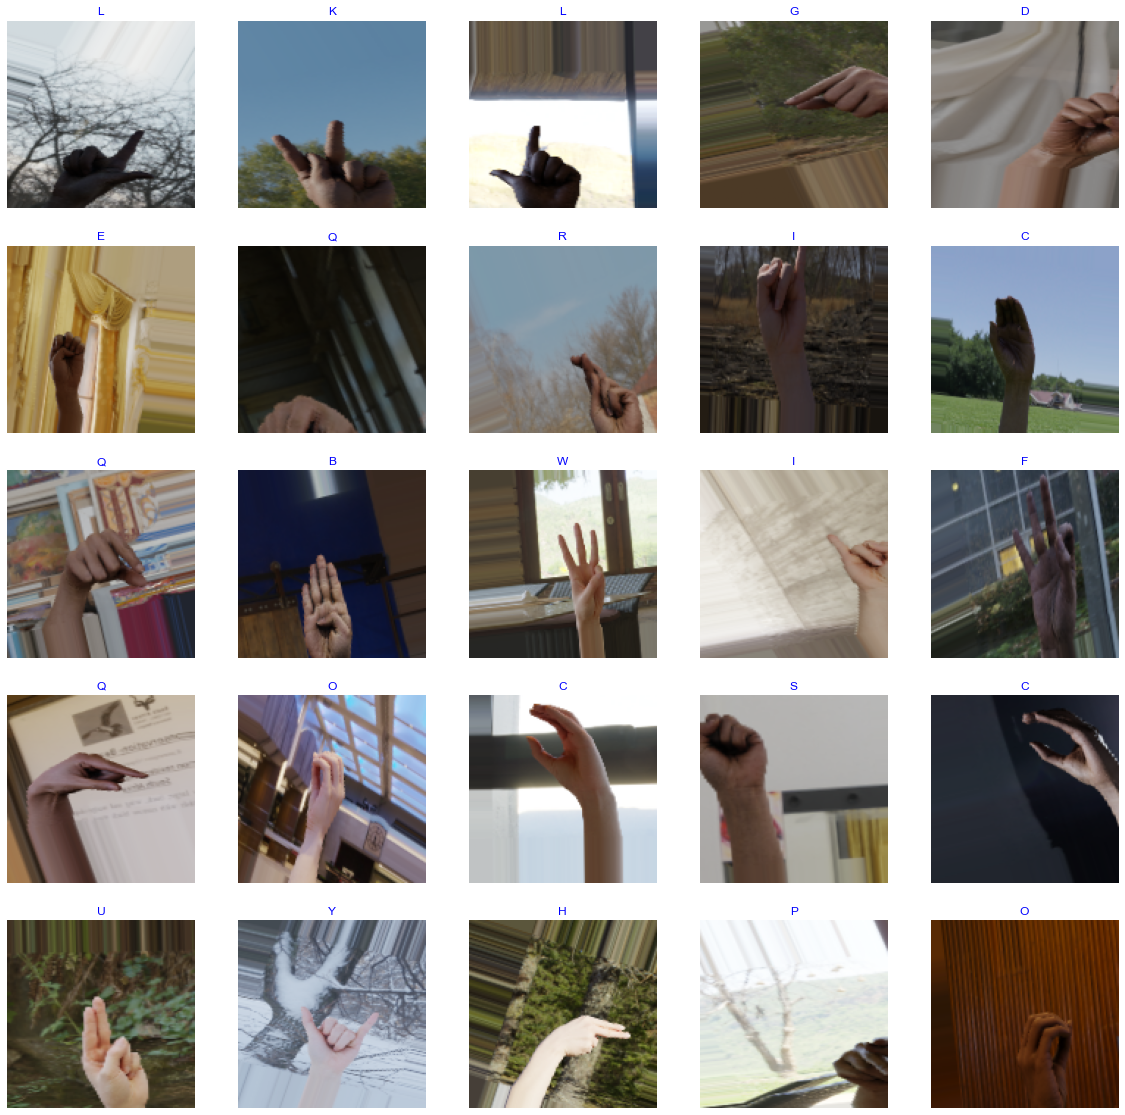

In [6]:
train_gen, test_gen, valid_gen = load_dataset(train_path, test_path,
                                             max_samples = max_samples,
                                             min_samples = min_samples,
                                             img_size = img_size,
                                             batch_size = batch_size,
                                             horizontal_flip = horizontal_flip,
                                             rotation_range = rotation_range,
                                             width_shift_range = width_shift_range,
                                             height_shift_range = height_shift_range,
                                             zoom_range = zoom_range)

### Arhitektura - Učitavanje EfficientNetB3

In [13]:
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels

img_shape = (img_size[0], img_size[1], 3)
model_name = 'EfficientNetB3'
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, input_shape=img_shape, pooling='max')
base_model.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l = 0.016), activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)

output = Dense(class_count, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

lr=.005
model.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 128, 128, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

 block2a_expand_activation (Act  (None, 64, 64, 144)  0          ['block2a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 65, 65, 144)  0          ['block2a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 32, 32, 144)  1296       ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 32, 32, 144)  576        ['block2a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 32, 32, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_s

                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 16, 16, 288)  0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_p

                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 8, 8, 288)    0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 8, 8, 96)     27648       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_p

 block4c_project_bn (BatchNorma  (None, 8, 8, 96)    384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 8, 8, 96)     0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 8, 8, 96)     0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 8, 8, 576)    55296       ['block4c_add[0][0]']            
                                                                                                  
 block4d_e

 block4e_add (Add)              (None, 8, 8, 96)     0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 8, 8, 576)    55296       ['block4e_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 8, 8, 576)   2304        ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 8, 8, 576)   0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 8, 8, 816)   20400       ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 8, 8, 816)   3264        ['block5c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 8, 8, 816)   0           ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_s

 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 8, 8, 816)   0           ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 816)         0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 816)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_s

                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 4, 4, 1392)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_p

 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 4, 4, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 4, 4, 232)    322944      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 4, 4, 232)   928         ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_d

 block6f_project_conv (Conv2D)  (None, 4, 4, 232)    322944      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 4, 4, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 4, 4, 232)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 4, 4, 232)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block7a_e

 top_conv (Conv2D)              (None, 4, 4, 1536)   589824      ['block7b_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 4, 4, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 4, 4, 1536)   0           ['top_bn[0][0]']                 
                                                                                                  
 max_pool (GlobalMaxPooling2D)  (None, 1536)         0           ['top_activation[0][0]']         
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 1536)        6144        ['max_pool[0][0]']               
 rmalization)                                                                                     
          

In [41]:
# epochs = 100
# ask_epoch = 40
# ask = LR_ASK(model, epochs,  ask_epoch)
# #rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
# #callbacks=[rlronp, ask]
# callbacks = [ask]

### Trening

In [16]:
epoch = 200
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)

In [20]:
history = model.fit(
                    x=train_gen,
                    epochs=epoch, 
                    verbose=1,  
                    validation_data=valid_gen,
                    validation_steps=None,  
                    shuffle=False,  
                    initial_epoch=0,
                    callbacks=[es_callback]
)

Epoch 1/200
240/240 [==============================] - 3429s 13s/step - loss: 7.3258 - accuracy: 0.2014 - val_loss: 4.2364 - val_accuracy: 0.4745
Epoch 2/200


KeyboardInterrupt: 

### Rezultati

In [21]:
plot_loss_and_acc(history)

NameError: name 'history' is not defined

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

### Čuvanje rezultata i modela

In [ ]:
METOD_NUM = 1
EKSP_NUM = 1

In [ ]:
zapisi_rezultate(METOD_NUM = METOD_NUM,
                 EKSP_NUM = EKSP_NUM,
                 acc = history.history['val_accuracy'],
                 loss = history.history['val_loss'],
                 val_acc = history.history['val_accuracy'],
                 val_loss = history.history['val_loss'])